In [2]:
import csv
from pathlib import Path
import SimpleITK as sitk
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from skimage.segmentation import clear_border
import scipy
from skimage import measure
import numpy as np
from multiprocessing import Pool, cpu_count
from skimage.morphology import convex_hull_image
import cv2
from scipy.ndimage import zoom
import os

In [215]:
def lumTrans(img):
    lungwin = np.array([-1200.,600.])
    newimg = (img-lungwin[0])/(lungwin[1]-lungwin[0])
    newimg[newimg<0]=0
    newimg[newimg>1]=1
    newimg = (newimg*255).astype('uint8')
    return newimg

def prepare(image, spacing):
    image_binary = scipy.ndimage.gaussian_filter(image, sigma=1, truncate=2.0) < -600
    image_without_borders = clear_border(image_binary)
    label = measure.label(image_without_borders)
    properties = measure.regionprops(label)
    valid_label = set()
    for prop in properties:
        if prop.area * spacing[0]*spacing[1] > 30 and prop.eccentricity < 0.99:
            valid_label.add(prop.label)

    image_without_trash = np.isin(label, list(valid_label)).reshape(label.shape)
    
    label = measure.label(image_without_trash)

    mask = np.zeros_like(image_without_trash, dtype=bool)

    for region in measure.regionprops(label):
        mask1 = np.ascontiguousarray(region.filled_image)
        mask[region.slice] |= convex_hull_image(mask1)

    return mask, lumTrans(np.where(mask, image, 170))

def isCircleInMask(mask, center, radius):
    # image is z, y, x
    x = center[1]
    y = center[0]

    count = 0

    for i in range(-1,2,2):
        for j in range(-1,2,2):
            xi = max(0, min(x + (i * radius), mask.shape[0] - 1))
            yj = max(0, min(y + (j * radius), mask.shape[1] - 1))
            if mask[xi, yj] == 0:
                count += 1
    if count >= 3:
        return True
    return False

def process_many(datas):
    for data in datas:
        process(data)

def process(data):
    path, name, x, y ,z, diameter = data
    image_raw = sitk.ReadImage(path)
    image = sitk.GetArrayFromImage(image_raw)
    spacing = image_raw.GetSpacing()

    radius = int(float(diameter) / spacing[0] / 2)

    physical_point = (float(x), float(y), float(z))
    index = image_raw.TransformPhysicalPointToIndex(physical_point)
    mask, image = prepare(image[index[2]], spacing)

    if isCircleInMask(mask, index, radius):
        print(path)
        return
    
    nodule = np.zeros(image.shape)
    cv2.circle(nodule, (index[0], index[1]), radius, 1, -1)

    resized_image = zoom(image, zoom=spacing[0], order=1)
    resized_nodule = zoom(nodule, zoom=spacing[0], order=1)

    target_size = 512

    pad_y = target_size - resized_image.shape[0]
    pad_x = target_size - resized_image.shape[1]

    pad_top = pad_y // 2
    pad_bottom = pad_y - pad_top
    pad_left = pad_x // 2
    pad_right = pad_x - pad_left

    padded_image = np.pad(resized_image, 
                        ((pad_top, pad_bottom), (pad_left, pad_right)), 
                        mode='constant', constant_values=194)
    
    padded_nodule = np.pad(resized_nodule, 
                        ((pad_top, pad_bottom), (pad_left, pad_right)), 
                        mode='constant', constant_values=False)

    padded_nodule = padded_nodule.astype(bool)

    padded_image.tofile(f"../processedData/image_{name}")
    padded_nodule.tofile(f"../processedData/mask_{name}")
    

In [216]:
root = Path("../data")

data_read = []

with open("../data/annotations.csv", newline='', encoding='utf-8') as file:
    reader = csv.reader(file)
    next(reader)
    for row in reader:
        name, x, y ,z, diameter = row
        path = next(root.rglob(name + ".mhd"), None)
        if path == None:
            print(name)
        data_read.append((str(path), name, x, y, z, diameter))

In [217]:
n_workers = cpu_count()
data_array = np.array(data_read)
chunks = np.array_split(data_array, n_workers)

if __name__ == "__main__":
    with Pool(n_workers) as p:
        results = p.map(process_many, chunks)

../data/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.188059920088313909273628445208.mhd
../data/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188376349804761988217597754952.mhd
../data/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.129982010889624423230394257528.mhd
../data/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.133378195429627807109985347209.mhd
../data/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.134996872583497382954024478441.mhd
../data/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.478062284228419671253422844986.mhd
../data/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.161855583909753609742728521805.mhd
../data/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.300270516469599170290456821227.mhd
../data/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.242761658169703141430370511586.mhd
../data/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.868211851413924881662621747734.mhd


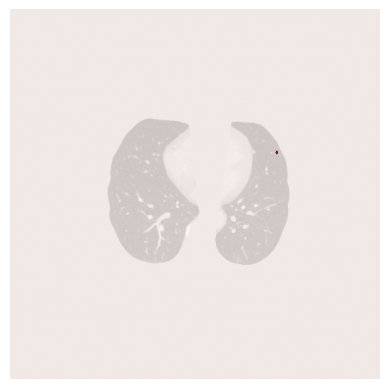

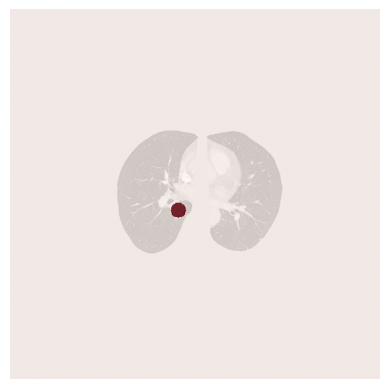

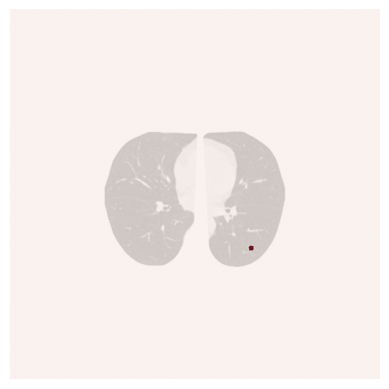

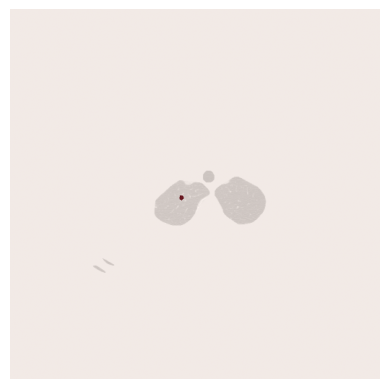

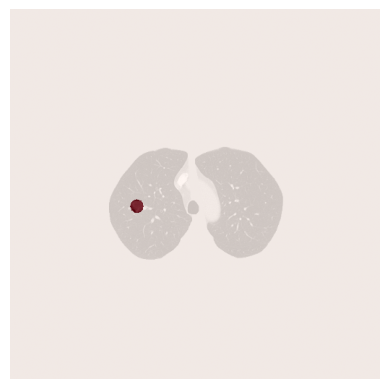

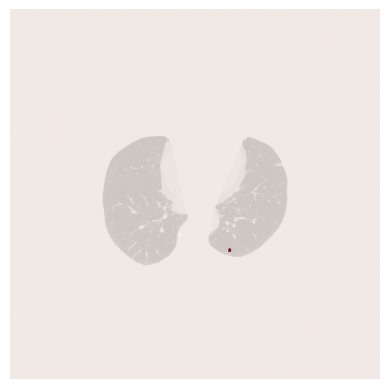

In [9]:
all_items = os.listdir("../processedData")
count = 0
for item in all_items:
    if item.startswith("mask_"):
        if count > 5:
            break
        count += 1 
        name= item[5:]
        padded_image = np.fromfile(f"../processedData/image_{name}", dtype=np.uint8)
        padded_image = padded_image.reshape((512,512))

        padded_nodule = np.fromfile(f"../processedData/mask_{name}", dtype=np.bool)
        padded_nodule = padded_nodule.reshape((512,512))

        plt.imshow(padded_image, cmap="gray") 
        plt.imshow(padded_nodule, cmap='Reds', alpha=0.8)

        plt.axis('off')
        plt.show()

    

